# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph

In [2]:
%pip install -qU "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database.

If we supply `":memory:"` it creates an in-memory Sqlite database.

In [4]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread= False)

But, if we supply a db path, then it will create a database for us!

In [7]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [8]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer

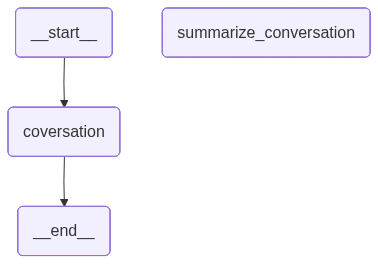

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("coversation",call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as coversation
workflow.add_edge(START, "coversation")
workflow.add_conditional_edges("coversation",should_continue)
workflow.add_edge("summarize_conversation",END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times

In [15]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Tharun")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the CSK!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello! You just introduced yourself as Lance a moment ago, and now you're saying your name is Tharun.

Which name would you prefer I use? Or is there a reason for the change?
================================== Ai Message ==================================

You've told me two names so far:

1.  First, you introduced yourself as **Lance**.
2.  Then, you introduced yourself as **Tharun**.

I'm a bit confused because of the two different names. Which one should I use for you?
================================== Ai Message ==================================

That's great! CSK, or the Chennai Super Kings, are a very successful team in the Indian Premier League (IPL).

What do you like most about them? Are you a fan of their players, their history, or their style of play?


In [16]:
input_message = HumanMessage(content="Tharun is correct.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Okay, thank you for clarifying! I will use **Tharun** for you from now on.

It's good to finally get that sorted out! So, Tharun, you were just telling me you like the CSK. What else would you like to chat about regarding them?


In [17]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Tharun is correct.', additional_kwargs={}, response_metadata={}, id='4d7cd5d0-8167-4d00-974a-33b954412efb'), AIMessage(content="Okay, thank you for clarifying! I will use **Tharun** for you from now on.\n\nIt's good to finally get that sorted out! So, Tharun, you were just telling me you like the CSK. What else would you like to chat about regarding them?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--77ab8b71-c074-42a3-90c1-a261384f789a-0', usage_metadata={'input_tokens': 346, 'output_tokens': 110, 'total_tokens': 456, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 51}})], 'summary': 'Okay, I will extend and correct the summary based on the full conversation history.\n\nHere\'s the extended and corrected summary of the conversation to date:\n\nThe co

### Persisting state

Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [18]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Tharun is correct.', additional_kwargs={}, response_metadata={}, id='4d7cd5d0-8167-4d00-974a-33b954412efb'), AIMessage(content="Okay, thank you for clarifying! I will use **Tharun** for you from now on.\n\nIt's good to finally get that sorted out! So, Tharun, you were just telling me you like the CSK. What else would you like to chat about regarding them?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--77ab8b71-c074-42a3-90c1-a261384f789a-0', usage_metadata={'input_tokens': 346, 'output_tokens': 110, 'total_tokens': 456, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 51}})], 'summary': 'Okay, I will extend and correct the summary based on the full conversation history.\n\nHere\'s the extended and corrected summary of the conversation to date:\n\nThe co